In [1]:
%load_ext autoreload
%autoreload 2
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget
import rawpy
import numpy as np
import io
from PIL import Image
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt

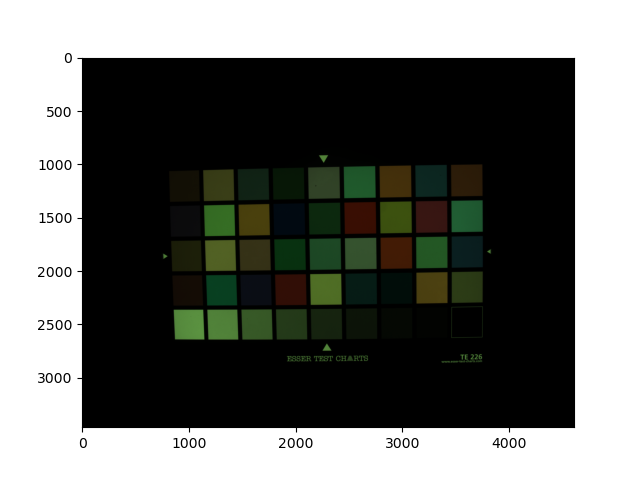

In [12]:
from digitalimage import DigitalImage

g81_img = DigitalImage("data\digital\P1480487.RW2", 1)
plt.figure()
plt.imshow(g81_img.raw)

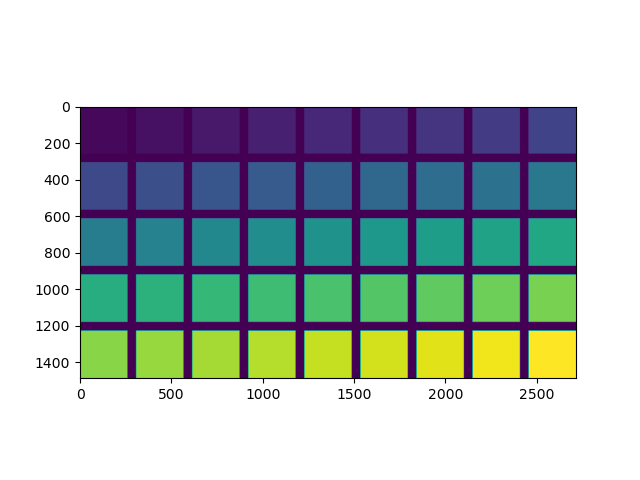

In [13]:
from colorchecker import ColorChecker

TE226 = ColorChecker(5, 9, 260, 47)
fig_checker = plt.figure()
plt.imshow(TE226.np_array)

Output()

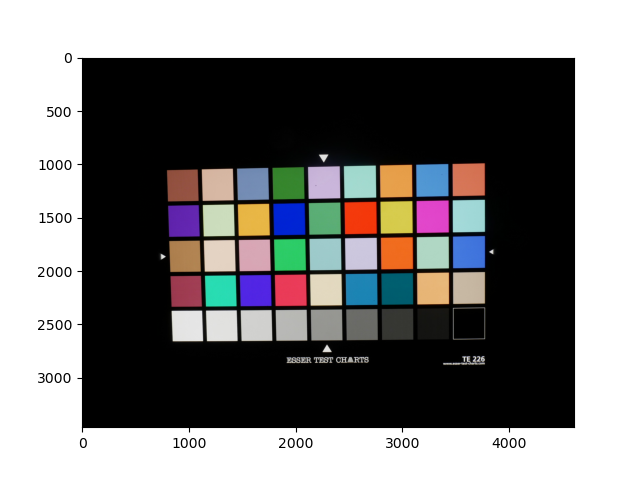

In [15]:
from colorchecker import ColorCheckerReadings

TE226_g81_reading = ColorCheckerReadings(TE226, g81_img.raw)
TE226_g81_reading.locate_color_checker(g81_img.thumbnail)

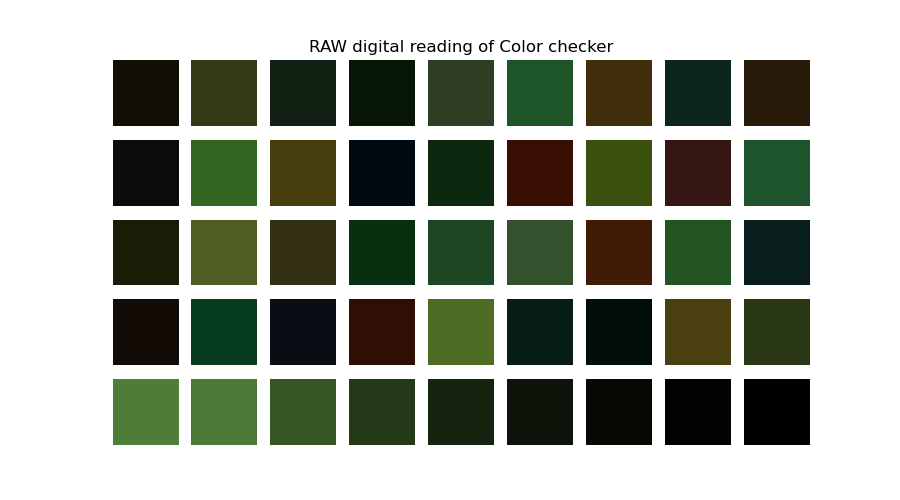

In [16]:
TE226_g81_reading.plot_patches("RAW digital reading of Color checker")

# TIF processing pipeline

Output()

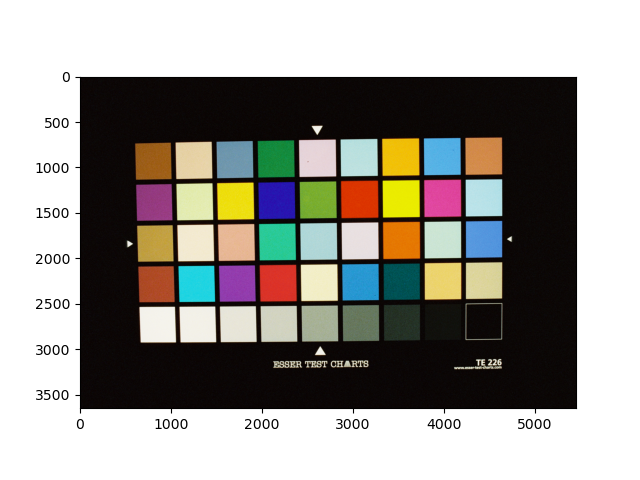

In [17]:
tif = Image.open("data/film/A002382raphael-R1-20-21.TIF")
tif_array = np.array(tif) / 255
plt.close('all')
TE226_800t_reading = ColorCheckerReadings(TE226, tif_array)
TE226_800t_reading.locate_color_checker()

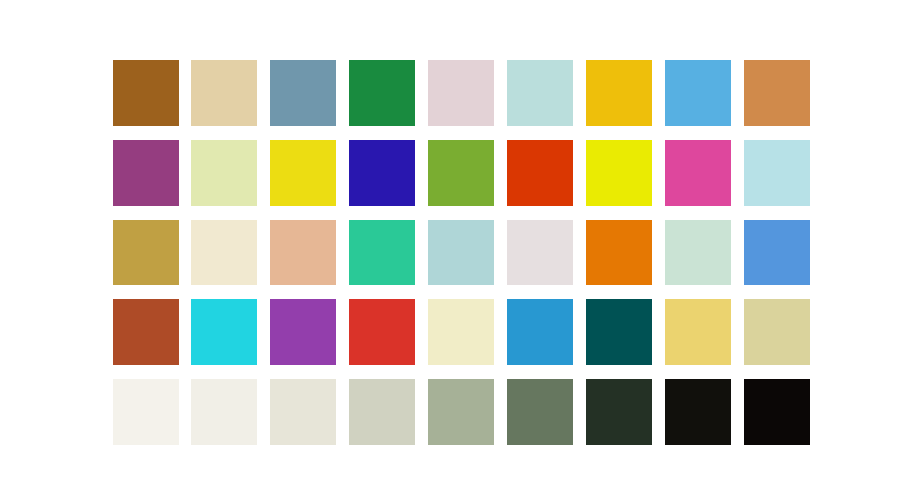

In [18]:
TE226_800t_reading.plot_patches()

## Linearize Tif

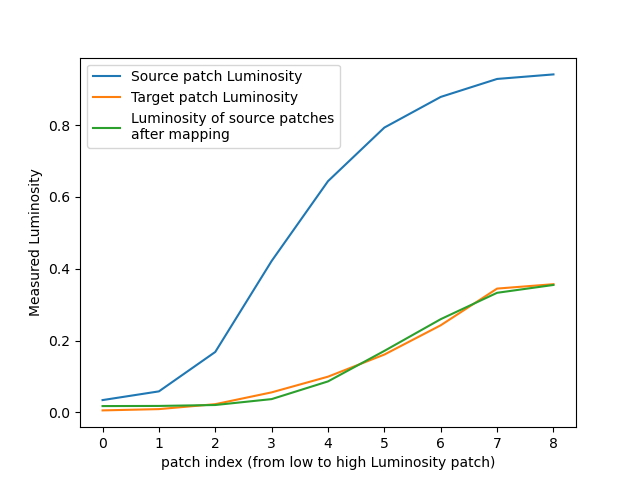

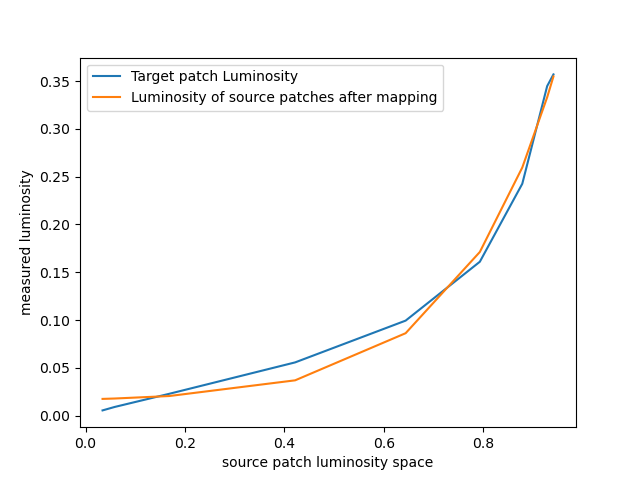

In [62]:
from linearization import Exponential, LinearExponential

plt.close('all')

my_exp = Exponential(TE226_800t_reading.patch_data[-9:], TE226_g81_reading.patch_data[-9:])
my_exp.plot_luminosity()
my_exp.plot_mapping()

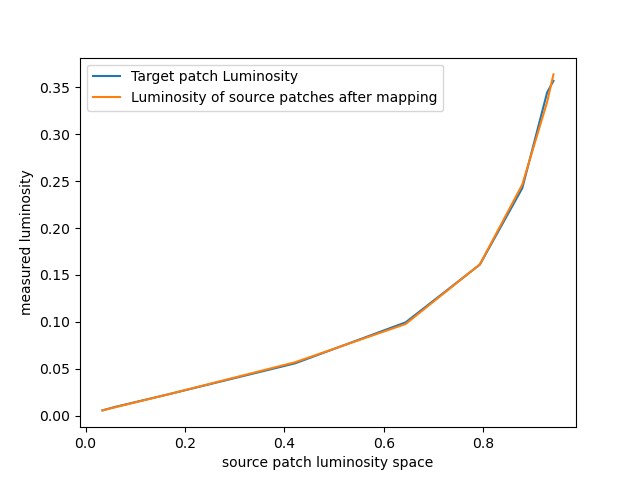

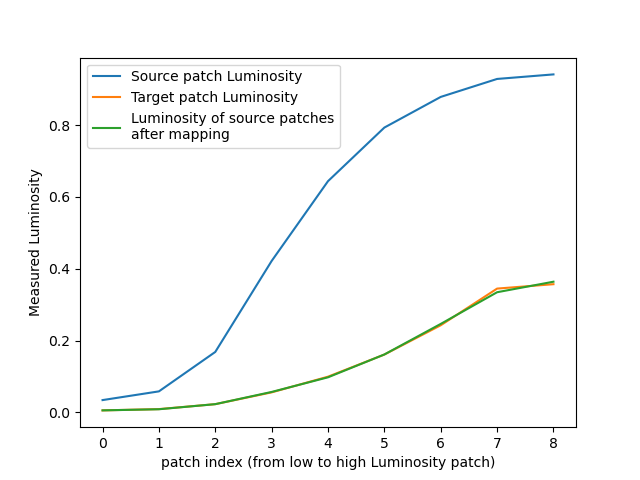

In [68]:
my_lin_exp = LinearExponential(TE226_800t_reading.patch_data[-9:], TE226_g81_reading.patch_data[-9:])
my_lin_exp.plot_mapping()
my_lin_exp.plot_luminosity()

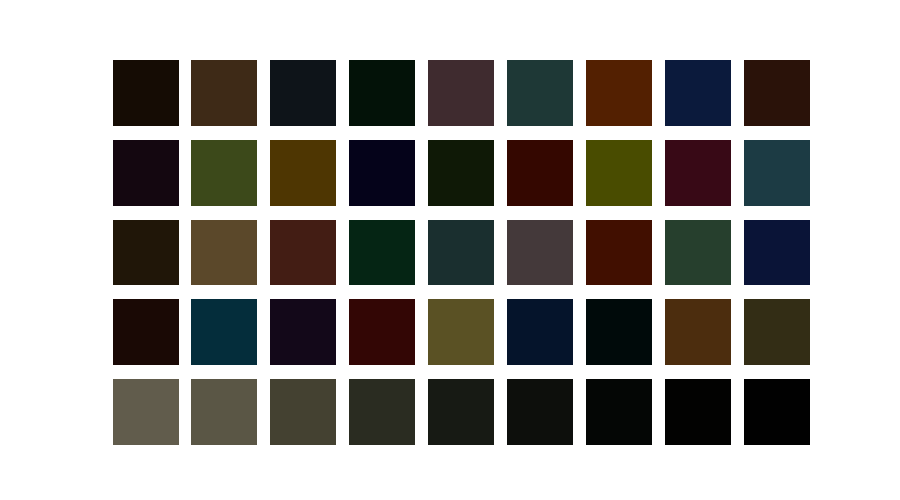

In [24]:
TE226_800t_linearized_reading = TE226_800t_reading.apply_transformation(func, popt)
TE226_800t_linearized_reading.plot_patches()

# Calculate Transfer Function

In [29]:
from colortransfer import ColorTransfer

poly = ColorTransfer(['r', 'g', 'b', 'rg', 'rb', 'gb', 'rr', 'gg', 'bb', 'rgb', '1'], TE226_g81_reading.patch_data, TE226_800t_linearized_reading.patch_data)

In [30]:
g81_modified_image = poly.apply(g81_img.raw, lambda image: inv_func(image, *popt))

C:\Users\GunMetal\AppData\Local\Temp\ipykernel_17092\3190054271.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.float32((-c * lambertw((a*b*np.exp(b*(y-d)/c))/c)-b*d+b*y) / (b*c))


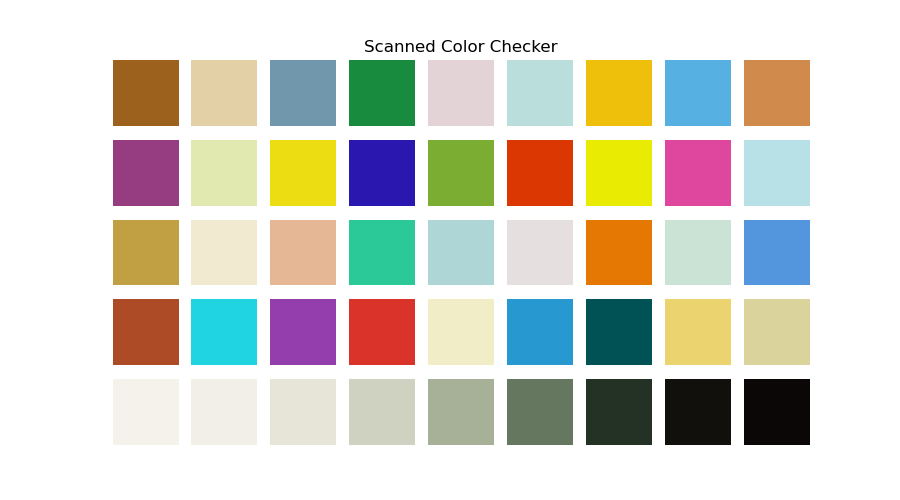

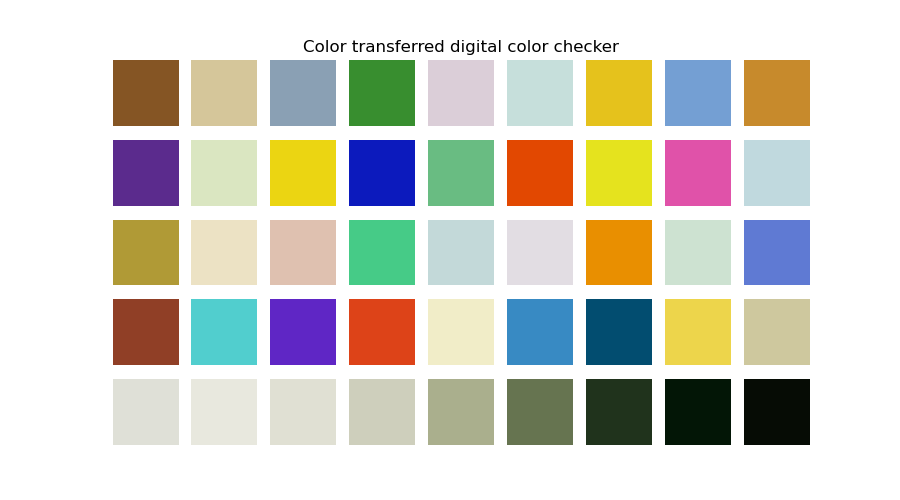

In [31]:
plt.close('all')
TE226_800t_reading.plot_patches("Scanned Color Checker")
TE226_G81_updated_readings = TE226_g81_reading.apply_new_image(g81_modified_image)
TE226_G81_updated_readings.plot_patches("Color transferred digital color checker")

## Calculating Color Distance

In [32]:
np.sum(np.linalg.norm(TE226_800t_reading.patch_data - TE226_G81_updated_readings.patch_data, axis=1))
# sRGB inverse tif: 6.058066025950642
# raw tif: 10.354313048359437
# exponential fitting tif: 5.8196292612243505
# affine fitting tif: 5.123900047000643
# affine + bb = 5.038549887154095
# affine + bb + better fitting tif 4.132495471413496
# affine + better fitting tif 4.10758754330378
# full poly with better cropped color checkers and affine + exponential linearization + 2 stops exposure: 3.695711209691901

4.270926500797167

# Applying color transform

C:\Users\GunMetal\AppData\Local\Temp\ipykernel_3556\3190054271.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.float32((-c * lambertw((a*b*np.exp(b*(y-d)/c))/c)-b*d+b*y) / (b*c))


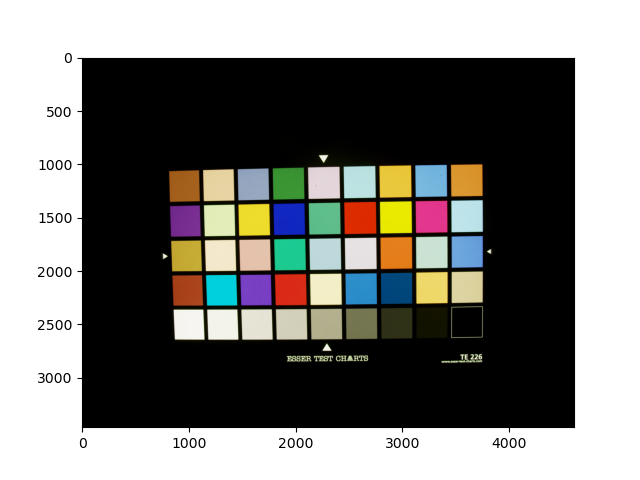

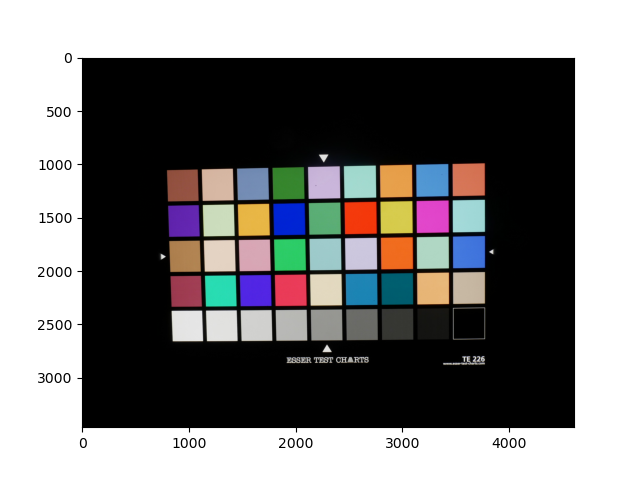

In [44]:
test_img = DigitalImage("data\digital\P1480487.RW2", 2)
modified = poly.apply(test_img.raw, lambda image: inv_func(image, *popt))
plt.figure()
plt.imshow(modified)
plt.figure()
plt.imshow(test_img.thumbnail)
Image.fromarray(np.uint8(modified*255)).save("out.png")

# Failed tests

In [ ]:
import cv2

In [ ]:
# test 1: square detection
# Load image, grayscale, and Otsu's threshold
nparr = np.asarray(bytearray(thumb), dtype="uint8")
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY )[1]

# thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

# Find contours
cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Filter for rectangles and squares
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    if len(approx) == 4:
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 3)
# Display the image
cv2.imshow('Detected Rectangles and Squares', image)
cv2.waitKey(0)

In [ ]:
# test 2: Hough line transform
# Load image, grayscale, Canny edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
# Use HoughLinesP to detect lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
# Display the image
cv2.imshow('Hough Lines', image)
cv2.waitKey(0)

In [ ]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(b * x) + c

def inv_func(y, a, b, c):
    assert a != 0
    assert b != 0
    return np.log(np.maximum((y-c)/a, 10e-5)) / b

popt, pcov = curve_fit(func, sorted_800t_patches, sorted_g81_patches, bounds=(0, [10, 10, 10]))
plt.figure()

plt.plot(sorted_800t_patches, sorted_g81_patches)
plt.plot(sorted_800t_patches, func(sorted_800t_patches, *popt),
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt